# Evals

Min Train Loss: 2.921425
Min Validation Loss: 3.0728
Max Hellaswag eval: 0.3068


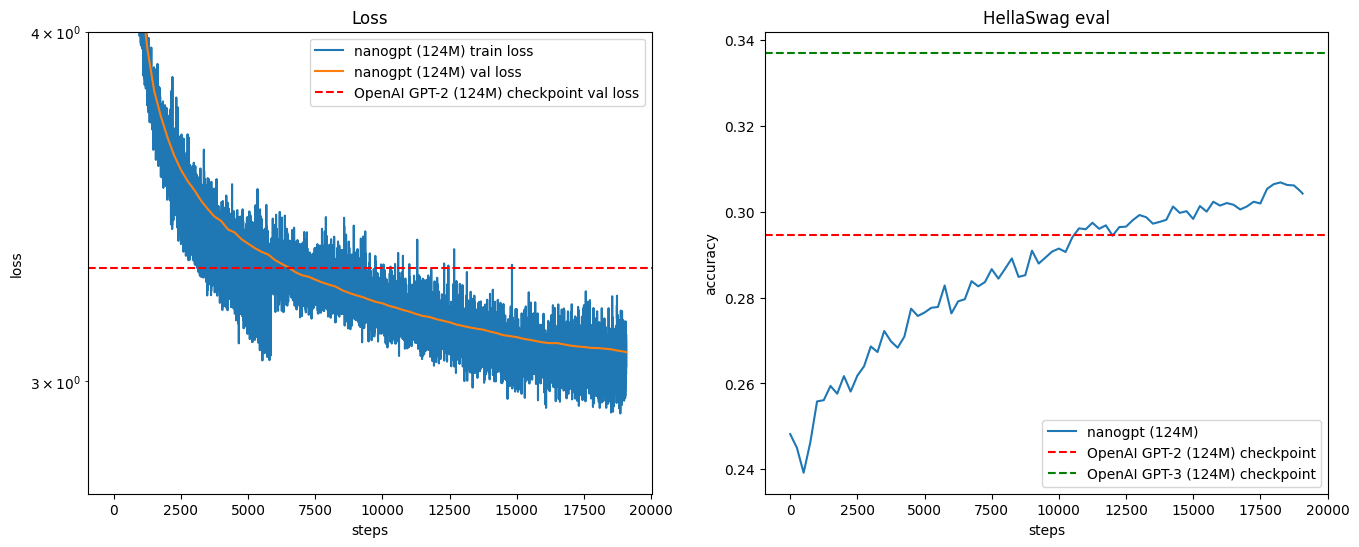

In [29]:
# parse and visualize the logfile
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

sz = "124M"

loss_baseline = {
    "124M": 3.2924,
}[sz]
hella2_baseline = { # HellaSwag for GPT-2
    "124M": 0.294463,
    "350M": 0.375224,
    "774M": 0.431986,
    "1558M": 0.488946,
}[sz]
hella3_baseline = { # HellaSwag for GPT-3
    "124M": 0.337,
    "350M": 0.436,
    "774M": 0.510,
    "1558M": 0.547,
}[sz]

# load the log file
with open("log/log.txt", "r") as f:
    lines = f.readlines()

# parse the individual lines, group by stream (train,val,hella)
streams = {}
for line in lines:
    step, stream, val = line.strip().split()
    if stream not in streams:
        streams[stream] = {}
    streams[stream][int(step)] = float(val)

# convert each stream from {step: val} to (steps[], vals[])
# so it's easier for plotting
streams_xy = {}
for k, v in streams.items():
    # get all (step, val) items, sort them
    xy = sorted(list(v.items()))
    # unpack the list of tuples to tuple of lists
    streams_xy[k] = list(zip(*xy))

# create figure
plt.figure(figsize=(16, 6))

# Panel 1: losses: both train and val
plt.subplot(121)
xs, ys = streams_xy["train"] # training loss
ys = np.array(ys)
plt.plot(xs, ys, label=f'nanogpt ({sz}) train loss')
print("Min Train Loss:", min(ys))
xs, ys = streams_xy["val"] # validation loss
plt.plot(xs, ys, label=f'nanogpt ({sz}) val loss')
# horizontal line at GPT-2 baseline
if loss_baseline is not None:
    plt.axhline(y=loss_baseline, color='r', linestyle='--', label=f"OpenAI GPT-2 ({sz}) checkpoint val loss")
plt.xlabel("steps")
plt.ylabel("loss")
plt.yscale('log')
plt.ylim(top=4.0)
plt.legend()
plt.title("Loss")
print("Min Validation Loss:", min(ys))

# Panel 2: HellaSwag eval
plt.subplot(122)
xs, ys = streams_xy["hella"] # HellaSwag eval
ys = np.array(ys)
plt.plot(xs, ys, label=f"nanogpt ({sz})")
# horizontal line at GPT-2 baseline
if hella2_baseline:
    plt.axhline(y=hella2_baseline, color='r', linestyle='--', label=f"OpenAI GPT-2 ({sz}) checkpoint")
if hella3_baseline:
    plt.axhline(y=hella3_baseline, color='g', linestyle='--', label=f"OpenAI GPT-3 ({sz}) checkpoint")
plt.xlabel("steps")
plt.ylabel("accuracy")
plt.legend()
plt.title("HellaSwag eval")
print("Max Hellaswag eval:", max(ys))

## Training & SFT curves (loss + HellaSwag)

These cells parse your existing outputs:
- `log/log.txt` from `train-model.py` (train/val loss + `hella` accuracy)
- `hf_sft_lora/**/trainer_state.json` from `sft_lora_ultrachat.py` (SFT loss)

Adjust the paths in the config cell if needed.


In [30]:
import os, json, re, glob
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---- CONFIG (edit if your folders differ)
PROJECT_ROOT = Path.cwd()  # run notebook from repo root
PRETRAIN_LOG = PROJECT_ROOT / "log" / "log.txt"
SFT_OUT_DIR  = PROJECT_ROOT / "hf_sft_lora"
HF_PRETRAIN_DIR = PROJECT_ROOT / "hf_pretrained"
HF_SFT_MERGED_DIR = PROJECT_ROOT / "hf_sft_merged"


In [31]:
def load_train_model_log(log_path: Path) -> pd.DataFrame:
    """Parses log/log.txt lines written by train-model.py:
       <step> train <loss>
       <step> val <loss>
       <step> hella <acc_norm>
    """
    if not log_path.exists():
        raise FileNotFoundError(f"Missing {log_path}. Are you in the right folder?")

    rows = []
    with log_path.open("r") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            parts = line.split()
            if len(parts) != 3:
                continue
            step_s, tag, value_s = parts
            if tag not in {"train", "val", "hella"}:
                continue
            try:
                step = int(step_s)
                value = float(value_s)
            except ValueError:
                continue
            rows.append({"step": step, "tag": tag, "value": value})

    df = pd.DataFrame(rows).sort_values(["tag", "step"]).reset_index(drop=True)
    return df

log_df = load_train_model_log(PRETRAIN_LOG)
log_df.head()


step    tag   value
0     0  hella  0.2482
1   250  hella  0.2450
2   500  hella  0.2392
3   750  hella  0.2463
4  1000  hella  0.2558

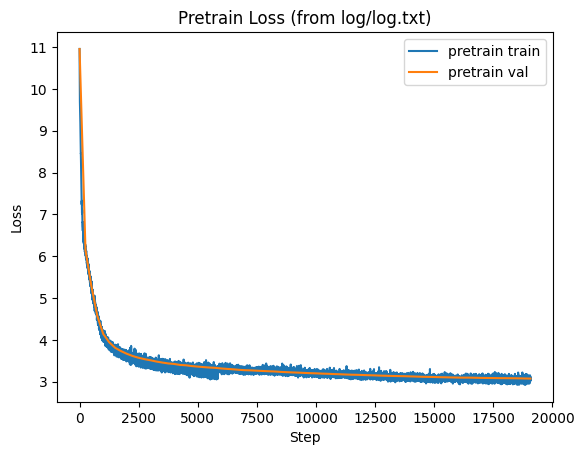

In [32]:
# Pretrain loss curves
plt.figure()

for tag in ["train", "val"]:
    sdf = log_df[log_df["tag"] == tag]
    if len(sdf):
        plt.plot(sdf["step"], sdf["value"], label=f"pretrain {tag}")

plt.title("Pretrain Loss (from log/log.txt)")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.legend()
plt.show()


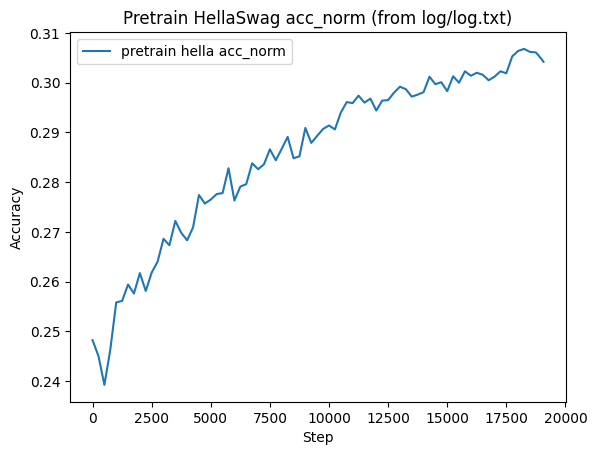

step    tag   value
73  18250  hella  0.3068
74  18500  hella  0.3062
75  18750  hella  0.3061
76  19000  hella  0.3047
77  19072  hella  0.3042

In [33]:
# Pretrain HellaSwag accuracy curve (acc_norm)
plt.figure()

sdf = log_df[log_df["tag"] == "hella"]
if len(sdf) == 0:
    print("No 'hella' entries found in log/log.txt. (Did you run the HellaSwag eval in train-model.py?)")
else:
    plt.plot(sdf["step"], sdf["value"], label="pretrain hella acc_norm")
    plt.title("Pretrain HellaSwag acc_norm (from log/log.txt)")
    plt.xlabel("Step")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

sdf.tail()


In [34]:
def find_latest_trainer_state(out_dir: Path) -> Path:
    candidates = list(out_dir.rglob("trainer_state.json"))
    if not candidates:
        raise FileNotFoundError(f"No trainer_state.json found under: {out_dir}")
    candidates.sort(key=lambda p: p.stat().st_mtime, reverse=True)
    return candidates[0]

def load_sft_trainer_loss(out_dir: Path) -> tuple[pd.DataFrame, Path]:
    ts_path = find_latest_trainer_state(out_dir)
    data = json.loads(ts_path.read_text())
    hist = data.get("log_history", [])
    df = pd.DataFrame(hist)

    # keep only rows with train loss
    if "loss" not in df.columns or "step" not in df.columns:
        raise ValueError(f"Unexpected trainer_state.json format at {ts_path}")
    df = df[df["loss"].notna()].copy()
    df = df.sort_values("step").reset_index(drop=True)
    return df, ts_path

sft_df, sft_state_path = load_sft_trainer_loss(SFT_OUT_DIR)
print("Using:", sft_state_path)
sft_df.head()


Using: /Users/shrithkshahapure/repos/ml-training/GPT/GPT2/GPT2/hf_sft_lora/checkpoint-3248/trainer_state.json


epoch  grad_norm  learning_rate    loss  step
0  0.007697   0.865831       0.000198  4.5355    25
1  0.015394   0.764203       0.000197  3.5518    50
2  0.023091   0.751974       0.000195  3.1554    75
3  0.030788   0.870010       0.000194  2.9737   100
4  0.038485   0.824100       0.000192  2.8744   125

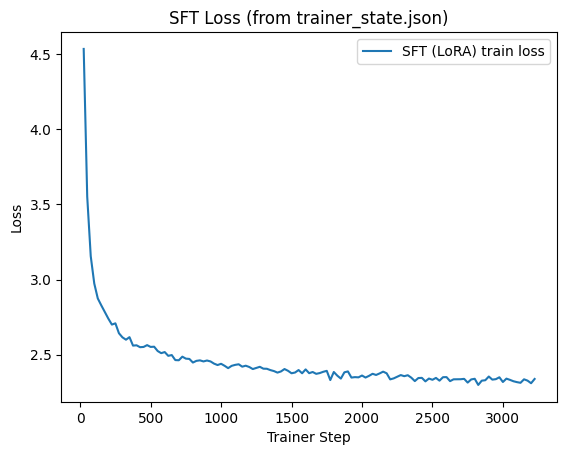

In [35]:
# SFT loss curve
plt.figure()
plt.plot(sft_df["step"], sft_df["loss"], label="SFT (LoRA) train loss")
plt.title("SFT Loss (from trainer_state.json)")
plt.xlabel("Trainer Step")
plt.ylabel("Loss")
plt.legend()
plt.show()


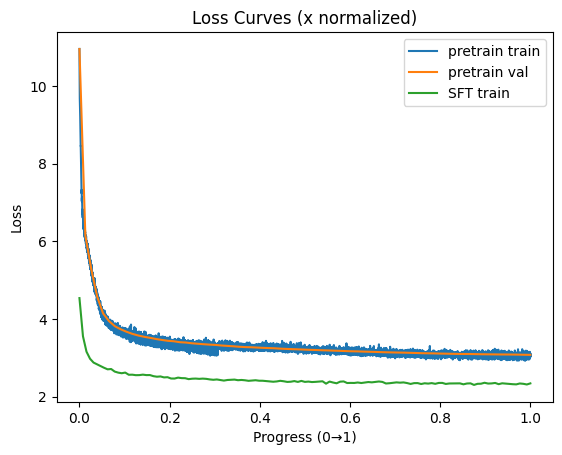

In [36]:
# Compare loss curve shapes (normalize x to 0→1 since step scales differ)
def normalize01(x):
    x = np.asarray(x, dtype=float)
    if len(x) == 0:
        return x
    lo, hi = float(np.min(x)), float(np.max(x))
    if hi == lo:
        return np.zeros_like(x)
    return (x - lo) / (hi - lo)

pre_train = log_df[log_df["tag"] == "train"]
pre_val   = log_df[log_df["tag"] == "val"]

plt.figure()

if len(pre_train):
    plt.plot(normalize01(pre_train["step"]), pre_train["value"], label="pretrain train")
if len(pre_val):
    plt.plot(normalize01(pre_val["step"]), pre_val["value"], label="pretrain val")
if len(sft_df):
    plt.plot(normalize01(sft_df["step"]), sft_df["loss"], label="SFT train")

plt.title("Loss Curves (x normalized)")
plt.xlabel("Progress (0→1)")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [ ]:
# Optional: run HellaSwag evals (pre vs post-SFT) and plot as a bar chart
# This runs evals.py as a subprocess and parses the final acc_norm printed.

import subprocess

def run_hellaswag_acc(model_dir: Path, device: str = "cpu") -> float:
    model_dir = Path(model_dir)
    if not model_dir.exists():
        raise FileNotFoundError(f"Missing model dir: {model_dir}")
    cmd = ["python", "evals.py", "-m", str(model_dir), "-d", device]
    p = subprocess.run(cmd, capture_output=True, text=True)
    if p.returncode != 0:
        raise RuntimeError(p.stderr[-2000:])

    matches = re.findall(r"acc_norm:\s*\d+/\d+=([0-9.]+)", p.stdout)
    if not matches:
        raise ValueError("Could not parse acc_norm from eval output.\n" + p.stdout[-2000:])
    return float(matches[-1])

# device: use 'cuda' if you have a GPU locally; otherwise 'cpu'
device = "mps"

pre_acc = run_hellaswag_acc(HF_PRETRAIN_DIR, device=device)
sft_acc = run_hellaswag_acc(HF_SFT_MERGED_DIR, device=device)

acc_df = pd.DataFrame([
    {"stage": "pretrained", "acc_norm": pre_acc},
    {"stage": "after_sft_merged", "acc_norm": sft_acc},
])

plt.figure()
plt.bar(acc_df["stage"], acc_df["acc_norm"])
plt.title("HellaSwag acc_norm (Pretrain vs After SFT)")
plt.xlabel("Stage")
plt.ylabel("Accuracy")
plt.show()

acc_df


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
